# Real-time modification of hybrid databases

This notebook builds on one of the examples provided in the "Brightway 2.5 demonstration", with more instructions and detail.

In this notebook, I give a specific example of how input data from a supplementary hybrid database could be processed before it is inserted into the matrix. In this case, we have uncertainty data from the supplementary database, but it doesn't fit into classic probability distributions, so needs some massaging beforehand.

In [1]:
%matplotlib inline

In [2]:
import bw2data as bd
import bw2calc as bc
import bw_processing as bwp
import numpy as np
import seaborn as sb
from scipy import stats
from matplotlib import pyplot as plt

This assumes you have this project, with the ecoinvent database installed.

In [3]:
bd.projects.set_current("ecoinvent 3.7.1")

# Create supplementary hybrid database structure

This isn't absolutely necessary, but it is convenient to have the metadata about these activities stored in the database.

In [4]:
co2 = next(x for x in bd.Database("biosphere3") 
           if x['name'] == 'Carbon dioxide, fossil'
           and x['categories'] == ('air',))
co2

'Carbon dioxide, fossil' (kilogram, None, ('air',))

In [5]:
hybrid = bd.Database("hybrid")
hybrid.write({
    ("hybrid", "a"): {
        'name': 'a',
        'exchanges': [{"input": co2.key, "type": "biosphere", "amount": 1}],
    },
    ("hybrid", "b"): {
        'name': 'b',
        'exchanges': [{"input": co2.key, "type": "biosphere", "amount": 10}],
    }
})

Writing activities to SQLite3 database:
0% [##] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/22/2021 13:59:34
  Finished: 04/22/2021 13:59:34
  Total time elapsed: 00:00:00
  CPU %: 59.90
  Memory %: 0.87


In [6]:
ha, hb = hybrid.get("a"), hybrid.get("b")
ha, hb

('a' (None, None, None), 'b' (None, None, None))

# The example model

We assume that two activities are missing some emissions found in the hybrid database, namely co2 emissions for copper and steel.

We are making up the numbers here!

We will model both missing inputs with kernel density estimators:

In [7]:
copper_ha_dist = stats.gaussian_kde([10, 12, 24, 48, 96, 100, 192], bw_method=0.125)

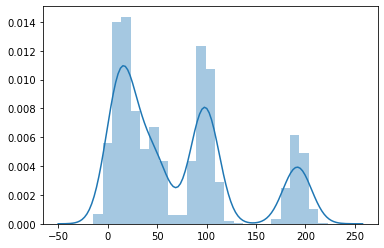

In [8]:
sb.distplot(copper_ha_dist.resample(size=5000))

In [9]:
steel_hb_dist = stats.gaussian_kde([50, 52, 54, 56, 78, 80, 84, 90], bw_method=0.125)

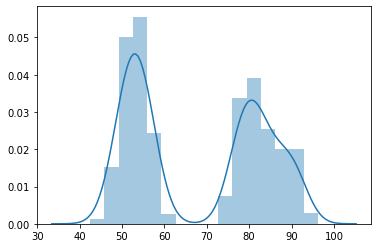

In [10]:
sb.distplot(steel_hb_dist.resample(size=5000))

# Define the interface

An [interface](https://github.com/brightway-lca/bw_processing/#persistent-versus-dynamic) is callable code that generates new data for insertion into the matrix each time the LCA object is iterated. The difference with e.g. normal parametric Monte Carlo is that the interface is a black box.

To define the interface, we have to fix some parameters. Specifically, we need to fix:

* The number of values that will be inserted
* The row and column indices of these values
* Their numerical sign

In our case, we are adding two new numbers to the matrix (the "a" and "b" activities also have two implied production exchanges; they could also be explicit, and defined in the `.write()` call above).

Our two values will be:

* Additional input of "a" to the market for copper
* Additional input of "b" to the market for steel

Therefore, the matrix indices will be:

In [11]:
copper = next(x for x in bd.Database("ecoinvent 3.7.1") if x['name'] == 'market for copper, cathode')

In [12]:
steel = next(x for x in bd.Database("ecoinvent 3.7.1") if x['name'] == 'market for steel, low-alloyed')

In [13]:
indices_array=np.array([
        (ha.id, copper.id), 
        (hb.id, steel.id)
    ],
    dtype=bwp.INDICES_DTYPE   
)

It is important to recognize that we give the `id` values here, not `Activity` objects. The `id` is just the database row id in the `activity` table.

The first column is the input consumed, the second column is the activity consuming the input. We hybridize by adding new inputs to ecoinvent.

In [14]:
indices_array

array([(23450, 11911), (23451, 15992)],
      dtype=[('row', '<i4'), ('col', '<i4')])

Next, we need to get the numerical sign. Both of these are inputs, so they are negative - their sign needs to be flipped.

In [15]:
flip_array=np.array([           
    True, True
])

Finally, we have the actual interface function. In this case, the underlying logic is in Python, but of course doesn't have to be.

Interfaces (for vectors) must support `__next__` and return a 1-d numpy array.

In [16]:
class Interface:
    def __next__(self):
        # Draw big samples to ensure we get a positive value
        arr = copper_ha_dist.resample(size=1000)
        mask = arr > 0
        copper = arr[mask][0] / 10

        arr = steel_hb_dist.resample(size=1000)
        mask = arr > 0
        steel = arr[mask][0] / 10

        print("Using copper and steel:", copper, steel)
        
        return np.array([copper, steel])    

In [17]:
hp = bwp.create_datapackage()

In [18]:
hp.add_dynamic_vector(
    matrix="technosphere_matrix",
    interface=Interface(),
    indices_array=indices_array,
    flip_array=flip_array,
)

# Use in LCA

In [19]:
car = next(x for x in bd.Database("ecoinvent 3.7.1") if x['name'] == 'transport, passenger car, electric')

In [20]:
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')

Include `ha` in the functional unit to make sure its database is included.

In [21]:
fu, data_objs, _ = bd.prepare_lca_inputs({car: 1, ha: 0}, method=ipcc)

Initial calculation without hybridization:

In [22]:
lca = bc.LCA(fu, data_objs=data_objs)
lca.lci()
lca.lcia()
print(lca.score)

0.2262365081398707


And now with stochastic hybridization:

In [23]:
lca = bc.LCA(fu, data_objs=data_objs + [hp])
lca.lci()
lca.lcia()
print(lca.score)

for _ in range(10):
    next(lca)
    print(lca.score)

Using copper and steel: 8.519454180121016 7.923457876513893
0.5144222527669274
Using copper and steel: 5.8781861347901465 7.8618302569018095
0.5102269638965717
Using copper and steel: 10.883392057685576 5.740103650908663
0.43858594703361237
Using copper and steel: 18.67336144441556 5.2787195684736785
0.42809200269009917
Using copper and steel: 5.395051428796012 8.071481702162695
0.5173146145945197
Using copper and steel: 18.657953079455794 5.199050050547309
0.42524763197290094
Using copper and steel: 17.74974815982225 5.460690232065916
0.4338612341235577
Using copper and steel: 1.5874533402459072 5.349794697912895
0.4176549543868344
Using copper and steel: 9.140548723630598 8.153613717307367
0.5230767929444486
Using copper and steel: 9.2159223407497 9.219702921007679
0.5610391828859612
Using copper and steel: 10.450133795630704 5.34759059502739
0.4243012586989031
